In [58]:
from utils.read_datasetBreakfast import load_data, read_mapping_dict
import os
import numpy as np


COMP_PATH = ''

''' 
training to load train set
test to load test set
'''
split = 'training'
#split = 'test'
train_split =  os.path.join(COMP_PATH, 'splits/train.exclude_val.bundle') #Train Split
test_split  =  os.path.join(COMP_PATH, 'splits/test.split1.bundle') #Test Split
GT_folder   =  os.path.join(COMP_PATH, 'groundTruth/') #Ground Truth Labels for each training video 
DATA_folder =  os.path.join(COMP_PATH, 'Data/') #Frame I3D features for all videos
mapping_loc =  os.path.join(COMP_PATH, 'splits/mapping_bf.txt') 

actions_dict = read_mapping_dict(mapping_loc)

data_feat, data_labels = load_data( train_split, actions_dict, GT_folder, DATA_folder, datatype = split) 

Finish Load the Training data and labels!!!


In [59]:
validation_split = os.path.join(COMP_PATH, 'splits/val.split1.bundle') #Validation split
val_data_feat, val_data_labels = load_data( validation_split, actions_dict, GT_folder, DATA_folder, datatype = split) #Get features and labels


Finish Load the Training data and labels!!!


In [60]:
import torch
from Dataset.VideoDataset import VideoDataset, VideoTrainDataset
import torch.utils.data as tud
from Models.LSTM import LSTM_Model
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
import torch.nn.utils as u

epochs = 200
batch_size = 50


learning_rate = 1e-3
log_interval = 50

def train(log_interval, cnnModel, rnnModel, device, train_loader, optimizer, epoch):
    cnnModel.train()
    rnnModel.train()
    
    losses = []
    scores = []
    for batch_idx, (in_feature, label) in enumerate(train_loader):
        in_feature = in_feature.to(device)
        label = label.to(device)
        #packed_input = u.rnn.pack_padded_sequence(in_feature, seq_length, batch_first=True, enforce_sorted=False).to(device)
        
        optimizer.zero_grad()
        cnnOutput = cnnModel(in_feature)
        output = rnnModel(cnnOutput)
        loss = F.cross_entropy(output, label)
        losses.append(loss.item())
        
        label_predict = torch.max(output, 1)[1]
        step_score = accuracy_score(label.cpu().data.squeeze().numpy(), label_predict.cpu().data.squeeze().numpy())
        scores.append(step_score)
        
        loss.backward()
        optimizer.step()
        
        if (batch_idx + 1) % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accu: {:.2f}%'.format(
                epoch + 1, (batch_idx+1)*batch_size, len(train_loader.dataset), 100. * (batch_idx + 1) / len(train_loader), loss.item(), 100 * step_score))
        
    return losses, scores

In [61]:
val_dataset = VideoDataset(val_data_feat, val_data_labels)
val_dataloader = tud.DataLoader(val_dataset)

def validation(cnnModel, rnnModel, device, test_loader):
    cnnModel.eval()
    rnnModel.eval()
    
    all_labels = []
    all_labels_predict = []
    with torch.no_grad():
        for in_feature, labels in test_loader:
            in_feature = in_feature.to(device)
            labels = labels.to(device)
            
            cnnOutput = cnnModel(in_feature)
            output = rnnModel(cnnOutput)
            
            labels_predict = torch.max(output, 1)[1]
            all_labels.extend(labels)
            all_labels_predict.extend(labels_predict.long())
            
    # compute accuracy
    all_labels = torch.stack(all_labels, dim=0)
    all_labels_predict = torch.stack(all_labels_predict, dim=0)
    test_score = accuracy_score(all_labels.cpu().data.squeeze().numpy(), all_labels_predict.cpu().data.squeeze().numpy())
    print('\nTest set ({:d} samples): Accuracy: {:.2f}%\n'.format(len(all_labels), 100* test_score))
    
    return test_score

In [44]:
import torch.nn as nn
class CnnEncoder(nn.Module):
    def __init__(self):
        super(CnnEncoder, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, 1, 3, stride=2,padding=1),
            nn.BatchNorm1d(1),
            nn.ReLU())
        
        self.conv2 = nn.Sequential(
            nn.Conv1d(1, 1, 3, stride=2, padding=1),
            nn.BatchNorm1d(1),
            nn.ReLU())
        
        self.pool = nn.AdaptiveMaxPool1d(5)
    def forward(self, x_frames):
        cnn_embed = []
        batchsize = x_frames.size(0)
        for i in range(x_frames.size(1)): #batch, frames, data_feature
            x = x_frames[:,i,:].view(batchsize,1,-1)
            x = self.conv1(x)
            x = self.conv2(x)
            x = x.view(batchsize, -1)
            cnn_embed.append(x)
        cnn_embed = torch.stack(cnn_embed, dim=0).transpose_(0, 1)
        return cnn_embed
        
    
        

In [62]:
import utils.balance_data as b
cuda_avail = torch.cuda.is_available()
device = torch.device("cuda" if cuda_avail else "cpu")

lstm = LSTM_Model(hidden_rnn_layers = 3, hidden_rnn_nodes = 86, bidirectional=False, fc_dim=64, I3D_feature_size = 100,
                 dropout_rate=0.3, output_size=48).double().to(device)
cnnModel = CnnEncoder().double().to(device)
optimizer = torch.optim.Adam(list(lstm.parameters()), lr=learning_rate, weight_decay = 1e-6)

# record training process
epoch_train_losses = []
epoch_train_scores = []
epoch_test_scores = []

label_dict = b.generate_label_dictionary(data_feat, data_labels)
total_segments = len(data_labels)
for epoch in range(epochs):
    new_data_feat, new_data_labels = b.balance_data(label_dict, total_segments)
    dataset = VideoTrainDataset(new_data_feat, new_data_labels, 50)
    dataloader = tud.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    train_losses, train_scores = train(log_interval, cnnModel, lstm, device, dataloader, optimizer, epoch)
    
    epoch_train_losses.append(train_losses)
    epoch_train_scores.append(train_scores)
    if (epoch+1) % 20 == 0:
        test_score = validation(cnnModel, lstm, device, val_dataloader)
        epoch_test_scores.append(test_score)

#torch.save(lstm.state_dict(), "./trained/lstm.pt")
A = np.array(epoch_train_losses)
B = np.array(epoch_train_scores)
D = np.array(epoch_test_scores)
#np.save('./results/lstm/training_losses_2.npy', A)
#np.save('./results/lstm/training_scores_2.npy', B)
#np.save('./results/lstm/test_loss.npy', C)
#np.save('./results/lstm/test_score.npy', D)

Train Epoch: 1 [2500/5640 (44%)]	Loss: 3.875111, Accu: 0.00%
Train Epoch: 1 [5000/5640 (88%)]	Loss: 3.657098, Accu: 4.00%
Train Epoch: 2 [2500/5640 (44%)]	Loss: 3.648169, Accu: 6.00%
Train Epoch: 2 [5000/5640 (88%)]	Loss: 3.710077, Accu: 0.00%
Train Epoch: 3 [2500/5640 (44%)]	Loss: 3.323606, Accu: 14.00%
Train Epoch: 3 [5000/5640 (88%)]	Loss: 3.339240, Accu: 14.00%
Train Epoch: 4 [2500/5640 (44%)]	Loss: 3.350956, Accu: 6.00%
Train Epoch: 4 [5000/5640 (88%)]	Loss: 3.079759, Accu: 16.00%
Train Epoch: 5 [2500/5640 (44%)]	Loss: 3.327333, Accu: 12.00%
Train Epoch: 5 [5000/5640 (88%)]	Loss: 3.491823, Accu: 6.00%
Train Epoch: 6 [2500/5640 (44%)]	Loss: 2.858307, Accu: 22.00%
Train Epoch: 6 [5000/5640 (88%)]	Loss: 3.198745, Accu: 14.00%
Train Epoch: 7 [2500/5640 (44%)]	Loss: 3.035512, Accu: 16.00%
Train Epoch: 7 [5000/5640 (88%)]	Loss: 2.906554, Accu: 24.00%
Train Epoch: 8 [2500/5640 (44%)]	Loss: 3.274845, Accu: 18.00%
Train Epoch: 8 [5000/5640 (88%)]	Loss: 2.864069, Accu: 22.00%
Train Epoch: 9

KeyboardInterrupt: 

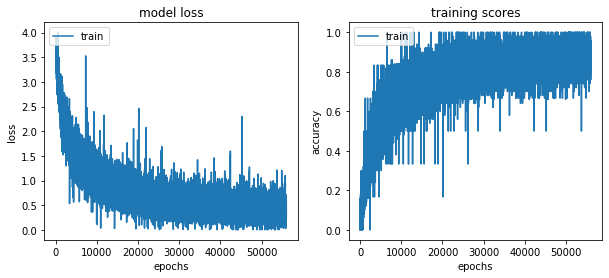

In [57]:
import matplotlib.pyplot as plt
import numpy as np

A = np.load('./results/lstm/training_losses2_2020-04-04.npy')
B = np.load('./results/lstm/training_scores2_2020-04-04.npy')

#C = np.load('./results/lstm/test_loss_2020-03-28.npy')
#D = np.load('./results/lstm/test_score_2020-03-29.npy')
fig = plt.figure(figsize=(10, 4))
plt.subplot(121)
#plt.plot(np.arange(1, epochs + 1), A[:, -1])  # train loss (on epoch end)
plt.plot(A.flatten())  # train loss (on epoch end)
#plt.plot(np.arange(1, epochs + 1), C)  
plt.title("model loss")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train','test'], loc="upper left")
# 2nd figure
plt.subplot(122)
#plt.plot(np.arange(1, epochs + 1), B[:, -1])
plt.plot(B.flatten())

epochs = 100
#plt.plot(D) # train accuracy (on epoch end)
plt.title("training scores")
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc="upper left")
plt.show()